In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt # Visualizations
from urllib.parse import unquote # Remove ASCII encodings

import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

2024-04-21 21:27:24.187338: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-21 21:27:24.187425: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-21 21:27:24.314154: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Step 1: Brief description of the problem and data (5 pts)
> Briefly describe the challenge problem and NLP. Describe the size, dimension, structure, etc., of the data. 

<u>**Author:**</u> Elizabeth Martin <br>
<u>**Github:**</u> (coming soon)**

<u>**Purpose:**</u> This is a **kaggle competition** designed to teach beginner data scientists how to work with NLP.  The goal is to develop a machine learning model to evaluate Tweets and determine if they are about natural disasters.  To accomplish this we will need to use a **Natural Language Processing (NLP)** approach, but first let's take a look at the dataset.

In [2]:
df_train = pd.read_csv("/kaggle/input/nlp-getting-started/train.csv")
df_test = pd.read_csv("/kaggle/input/nlp-getting-started/test.csv")

num_disasters = df_train['target'].sum()
num_non_disasters = (df_train['target'] == 0).sum()

print("--------- Training dataset details ---------")
print(f"Shape: {df_train.shape}")
print(f"Columns: {df_train.columns.tolist()}")
print(f"Number of unique keywords: {len(df_train['keyword'].unique())}")
print(f"Number of unique locations: {len(df_train['location'].unique())}")
print(f"Number of disaster occurrences: {num_disasters} & non-disaster occurrences: {num_non_disasters}")
print(f"(Sanity check for above: {num_disasters} + {num_non_disasters} = {num_disasters + num_non_disasters})")
print()
print("--------- Testing dataset details ---------")
print(f"Shape: {df_test.shape}")
print(f"Columns: {df_test.columns.tolist()}")
print(f"Number of unique keywords: {len(df_test['keyword'].unique())}")
print(f"Number of unique locations: {len(df_test['location'].unique())}")

# Add columns to dataframes for length of text
df_train["length"] = df_train["text"].apply(lambda x : len(x))
df_test["length"] = df_test["text"].apply(lambda x : len(x))


--------- Training dataset details ---------
Shape: (7613, 5)
Columns: ['id', 'keyword', 'location', 'text', 'target']
Number of unique keywords: 222
Number of unique locations: 3342
Number of disaster occurrences: 3271 & non-disaster occurrences: 4342
(Sanity check for above: 3271 + 4342 = 7613)

--------- Testing dataset details ---------
Shape: (3263, 4)
Columns: ['id', 'keyword', 'location', 'text']
Number of unique keywords: 222
Number of unique locations: 1603


In [3]:
df_train.head()

,id,keyword,location,text,target,length
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,69
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,38
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,133
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,65
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,88


In [4]:
df_test.head()

,id,keyword,location,text,length
0,0,NaN,NaN,Just happened a terrible car crash,34
1,2,NaN,NaN,"Heard about #earthquake is different cities, s...",64
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are...",96
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires,40
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan,45


---

# Step 2: Exploratory Data Analysis (EDA) — Inspect, Visualize and Clean the Data (15 pts)
> Show a few visualizations like histograms. Describe any data cleaning procedures. Based on your EDA, what is your plan of analysis? 

<u>**Histograms:**</u> Below are two histograms, the one of the left showing the distribution of text length per dataset (training & testing).  The histogram on the right shows the distribution of text length for each type of target (disaster or not).

<u>**Data cleaning:**</u> After these graphs I have also done some light data cleaning by removing ASCII encodings with the unquote method from the urllib.parse library.

<u>**Plan of analysis:**</u> 
1. The first step is to tokenize the text.  I will use the tokenizer from the Keras library which will convert the text into sequences of tokens that can be fed into a neural network.  
2. The next step is to pad the sequences so they all have the same length.  This is accomplished by adding zeros to the sequence.
3. Next will be the model creation to be covered in step 3

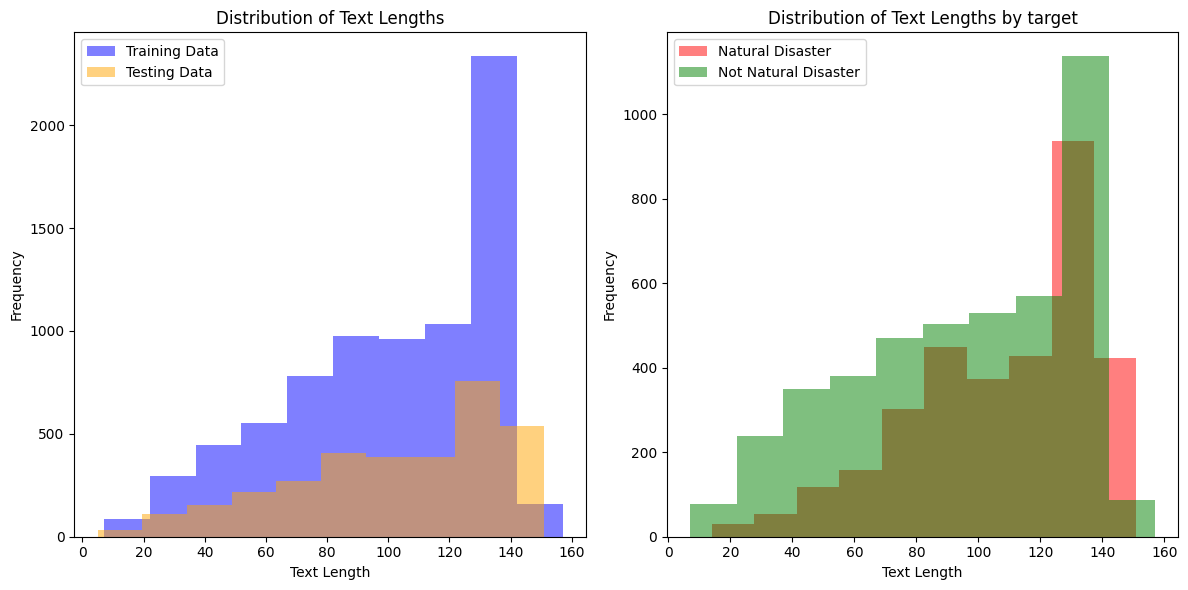

In [5]:
natural_disaster_lengths = df_train[df_train['target'] == 1]['length']
non_disaster_lengths = df_train[df_train['target'] == 0]['length']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6)) 

# Histogram showing length of text column in df_train and df_test
ax1.hist(df_train["length"], color='blue', alpha=0.5, label='Training Data')
ax1.hist(df_test["length"], color='orange', alpha=0.5, label='Testing Data')
ax1.set_xlabel('Text Length')
ax1.set_ylabel('Frequency')
ax1.set_title('Distribution of Text Lengths')
ax1.legend()

# Histogram showing length of texts for targets (disaster / not) in df_train
ax2.hist(natural_disaster_lengths, color='red', alpha=0.5, label='Natural Disaster')
ax2.hist(non_disaster_lengths, color='green', alpha=0.5, label='Not Natural Disaster')
ax2.set_xlabel('Text Length')
ax2.set_ylabel('Frequency')
ax2.set_title('Distribution of Text Lengths by target')
ax2.legend()

plt.tight_layout()
plt.show()

In [6]:
# Remove ASCII encodings from keywords
for index, row in df_train.iterrows():
    keyword = row['keyword']
    if not pd.isna(keyword):
        decoded_keyword = unquote(keyword)
        # print(f"Keyword: {keyword} -> {decoded_keyword}")
        # Update the 'keyword' column in df_train
        df_train.at[index, 'keyword'] = decoded_keyword

for index, row in df_test.iterrows():
    keyword = row['keyword']
    if not pd.isna(keyword):
        decoded_keyword = unquote(keyword)
        # print(f"Keyword: {keyword} -> {decoded_keyword}")
        # Update the 'keyword' column in df_train
        df_test.at[index, 'keyword'] = decoded_keyword

In [7]:
max_length = 157 # From above histograms & analysis

tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train['text'])
X_train = tokenizer.texts_to_sequences(df_train['text'])
X_train = pad_sequences(X_train, maxlen=max_length) 
y_train = df_train['target']

---

# Step 3: Model Architecture (25 pts)
> Describe your model architecture and reasoning for why you believe that specific architecture would be suitable for this problem. 

<u>**Model architecture:**</u> For my neural network, I have three layers:
1. An embedding layer which learns the dense vector representations of words
2. A **Long Short Term Memory (LSTM)** layer with 100 cells - LSTM is well-suited for processing sequential data
3. A dense layer (i.e., every neuron is connected to every other neuron in the previous LSTM layer) with a sigmoid activation function as this is a binary classification task

To compile the model, I chose to use the adam optimizer & a new loss function I read about, the binary cross entropy function, which penalizes the model when it makes confident wrong predictions, encouraging it to output high probabilities for positive examples & low probabilities for negative examples.


<u>**Reasoning:**</u> This architecture seems to work well, and I have done a bit of reading for the different types of layers.  The first one, the embedded layer, is common for text classification.  It helps to generalize and represent words with similar meanings as closer together in the embedding space.  The second layer, I mostly chose because it was one we learned about, but also because it is designed for sequential data, like text, and is capable of capturing long-term dependencies.  The final layer is normal for binary classification tasks.  

In [8]:
vocab_size = len(tokenizer.word_index) + 1  
embedding_dim = 100 # Come back and modify this if performance isn't sufficient

model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length))
model.add(LSTM(units=100))
model.add(Dense(units=1, activation='sigmoid'))  # best for binary classification

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:86: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


**Note: Commenting below cells as I've already submitted the notebook once with their results.  This will speed up the next submissions & testing.**

In [9]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [10]:
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - accuracy: 0.6576 - loss: 0.6065 - val_accuracy: 0.7728 - val_loss: 0.4903
Epoch 2/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8739 - loss: 0.3228 - val_accuracy: 0.7859 - val_loss: 0.4529
Epoch 3/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9441 - loss: 0.1515 - val_accuracy: 0.7768 - val_loss: 0.5125
Epoch 4/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9806 - loss: 0.0686 - val_accuracy: 0.7735 - val_loss: 0.6265
Epoch 5/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9862 - loss: 0.0439 - val_accuracy: 0.7676 - val_loss: 0.6475
Epoch 6/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9944 - loss: 0.0219 - val_accuracy: 0.7577 - val_loss: 0.7460
Epoch 7/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9936 - loss: 0.0206 - val_accuracy: 0.7183 - val_loss: 0.9187
Epoch 8/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9949 - loss: 0.0145 - val_accu

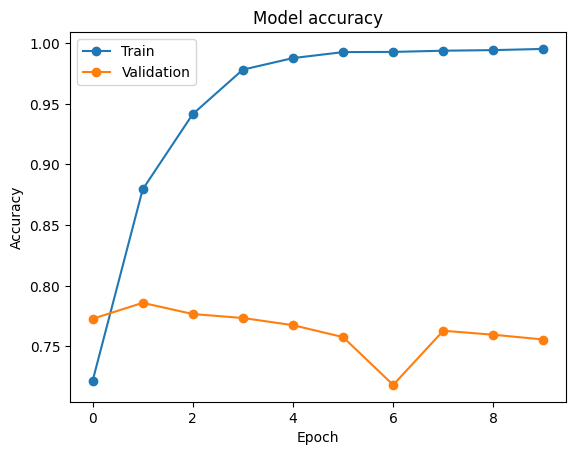

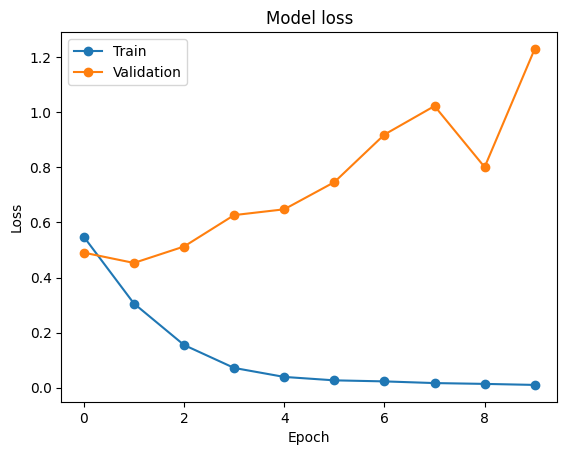

In [11]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'], marker='o')
plt.plot(history.history['val_accuracy'], marker='o')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'], marker='o')
plt.plot(history.history['val_loss'], marker='o')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [12]:
# X_test = tokenizer.texts_to_sequences(df_test['text'])
# X_test = pad_sequences(X_test, maxlen=max_length)

# predictions = model.predict(X_test)
# predicted_classes = (predictions > 0.5).astype('int32')

# submission_df = pd.DataFrame({'id': df_test['id'], 'target': predicted_classes.flatten()})
# submission_df.to_csv('submission.csv', index=False)

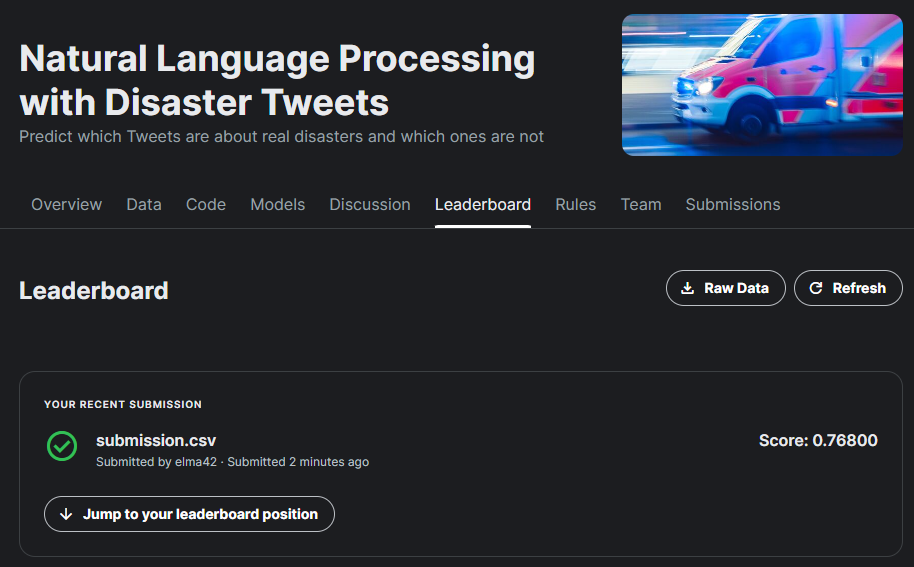

---

# Step 4: Results and Analysis (35 pts)
> Run hyperparameter tuning, try different architectures for comparison, apply techniques to improve training or performance, and discuss what helped.
>
> Includes results with tables and figures. There is an analysis of why or why not something worked well, troubleshooting, and a hyperparameter optimization procedure summary.

**Attempt 0:** For this next attempt I wanted to try adding a metric to the model compilation.  Since the leaderboard uses the F1 score, I wanted to see if it would make any difference to the outcome

In [13]:
from tensorflow.keras.metrics import Precision, Recall
import tensorflow as tf

def f1_score(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    
    true_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_true * y_pred, 0, 1)))
    predicted_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_pred, 0, 1)))
    possible_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_true, 0, 1)))

    precision = true_positives / (predicted_positives + tf.keras.backend.epsilon())
    recall = true_positives / (possible_positives + tf.keras.backend.epsilon())
    f1_val = 2 * (precision * recall) / (precision + recall + tf.keras.backend.epsilon())
    return f1_val


In [14]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', f1_score])

In [15]:
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.9923 - f1_score: 0.9911 - loss: 0.0143 - val_accuracy: 0.7190 - val_f1_score: 0.6473 - val_loss: 1.0134
Epoch 2/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9956 - f1_score: 0.9946 - loss: 0.0088 - val_accuracy: 0.7091 - val_f1_score: 0.6439 - val_loss: 1.2710
Epoch 3/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9957 - f1_score: 0.9949 - loss: 0.0121 - val_accuracy: 0.7413 - val_f1_score: 0.5872 - val_loss: 0.9932
Epoch 4/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9931 - f1_score: 0.9919 - loss: 0.0138 - val_accuracy: 0.7400 - val_f1_score: 0.6399 - val_loss: 0.9453
Epoch 5/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9957 - f1_score: 0.9948 - loss: 0.0085 - val_accuracy: 0.7479 - val_f1_score: 0.6153 - val_loss: 1.2367
Epoch 6/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9933 - f1_score: 0.9915 - loss: 0.0103 - val_accuracy: 0.7439 - val_f1_score: 

| Previous results to compare | After adding f1 score to model compilation|
| - | - |
| 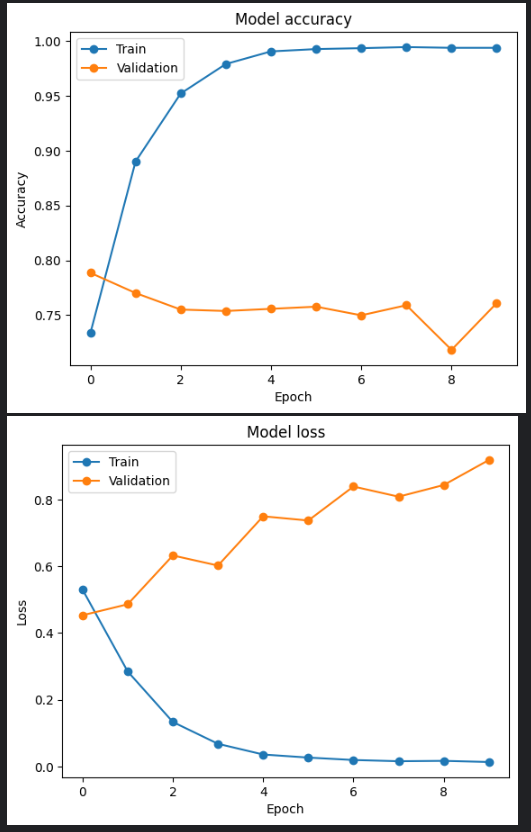 | 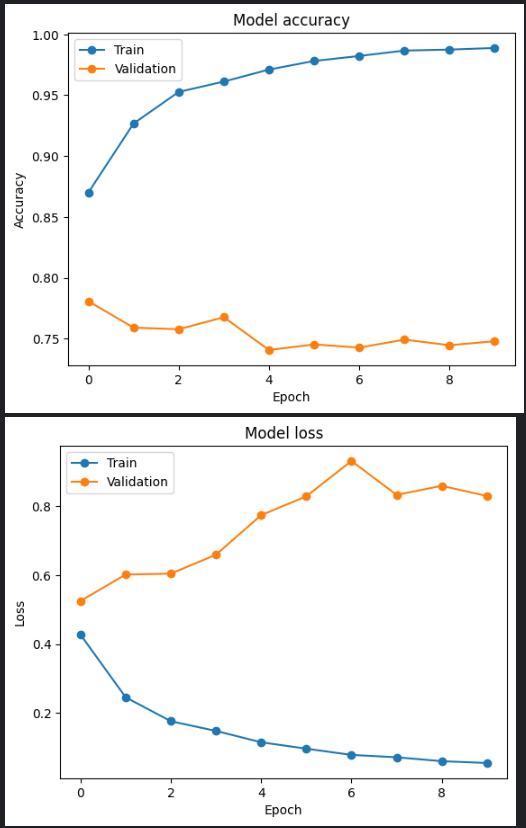 |

It looks like the model is overfitting. Let me try adding some dropout layers to see if it helps.  Also, it doesn't seem like adding the f1 score did too much to help.  I'll go ahead and remove it

**Attempt 1:** I added a 20% dropout rate and the model was slightly better, but still overfitting.  I'm going to add some regularization and try again
> Regularization adds a penalty term to the loss function, penalizing large weights in the model.  It should help with overfitting

**Attempt 2:** Adding a regularizer again helped, and the graphs are getting better, but let's keep going and reduce the learning rate

**Attempt 3:** Adding a learning rate helped and I can see the validation is more stable.  For my final submission I'm going to cut down the number of epochs based on this attempt to 3.

<u>**NOTE:** The below graphs are a bit misleading because I didn't keep the y axis frozen!! Apologies.</u>

| Attempt 1 results | Attempt 2 results | Attempt 3 results |
| ---------------- | - | - |
|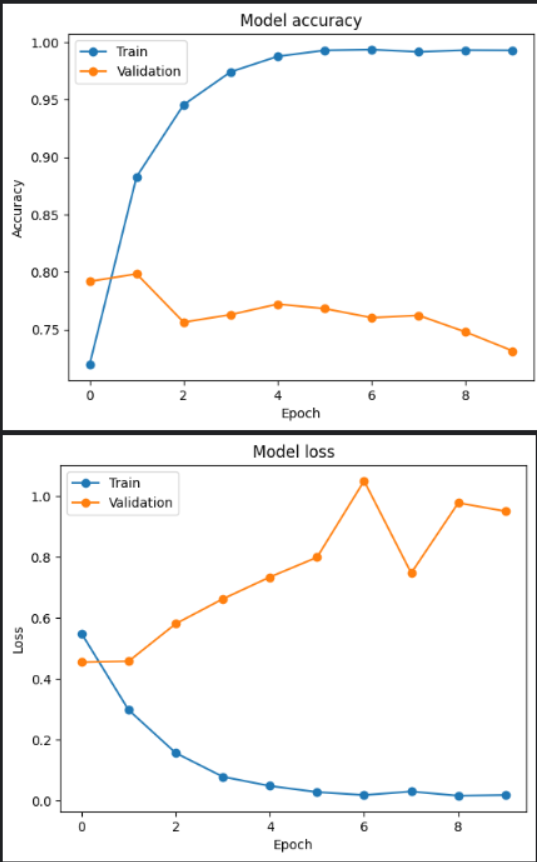 | 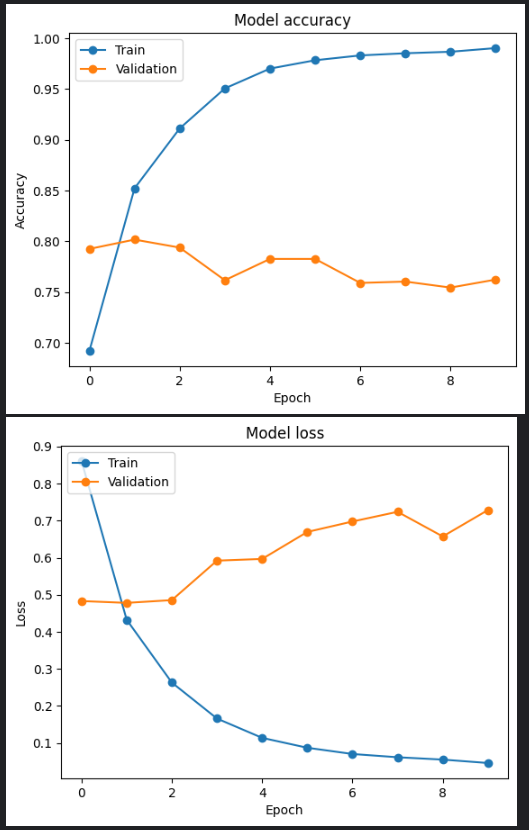 | 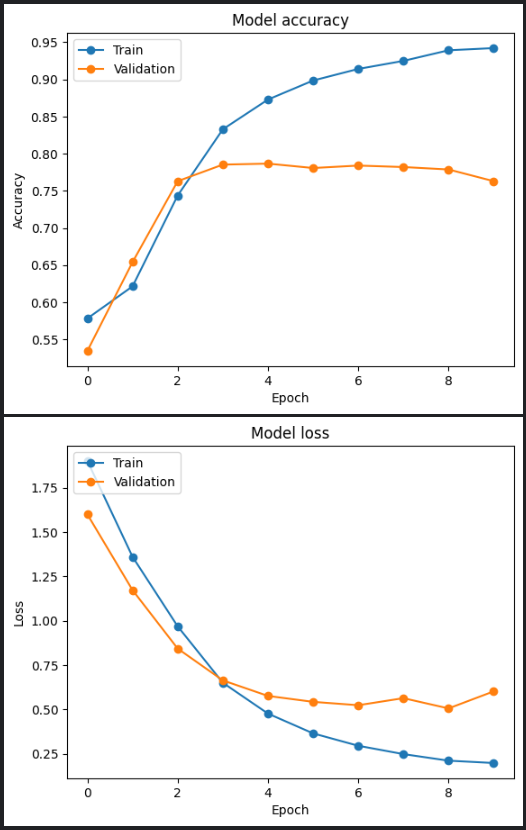 |

In [16]:
from tensorflow.keras.layers import Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length))
model.add(Dropout(0.2))  # Added dropout after Embedding layer
model.add(LSTM(units=100, kernel_regularizer=l2(0.01))) # Added regularizer
model.add(Dropout(0.2))  # Added dropout after LSTM layer
model.add(Dense(units=1, activation='sigmoid'))

optimizer = Adam(learning_rate=0.0001) # Added learning rate
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy']) # Removed f1 score

In [17]:
history = model.fit(X_train, y_train, epochs=3, batch_size=32, validation_split=0.2)

Epoch 1/3
191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.5728 - loss: 2.0971 - val_accuracy: 0.5345 - val_loss: 1.6117
Epoch 2/3
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.5946 - loss: 1.4837 - val_accuracy: 0.6205 - val_loss: 1.1898
Epoch 3/3
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.7163 - loss: 1.0724 - val_accuracy: 0.7525 - val_loss: 0.8569


In [18]:
# Not graphing, see above images

# # Plot training & validation accuracy values
# plt.plot(history.history['accuracy'], marker='o')
# plt.plot(history.history['val_accuracy'], marker='o')
# plt.title('Model accuracy')
# plt.ylabel('Accuracy')
# plt.xlabel('Epoch')
# plt.legend(['Train', 'Validation'], loc='upper left')
# plt.show()

# # Plot training & validation loss values
# plt.plot(history.history['loss'], marker='o')
# plt.plot(history.history['val_loss'], marker='o')
# plt.title('Model loss')
# plt.ylabel('Loss')
# plt.xlabel('Epoch')
# plt.legend(['Train', 'Validation'], loc='upper left')
# plt.show()

In [19]:
X_test = tokenizer.texts_to_sequences(df_test['text'])
X_test = pad_sequences(X_test, maxlen=max_length)

predictions = model.predict(X_test)
predicted_classes = (predictions > 0.5).astype('int32')

submission_df = pd.DataFrame({'id': df_test['id'], 'target': predicted_classes.flatten()})
submission_df.to_csv('submission.csv', index=False)

102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


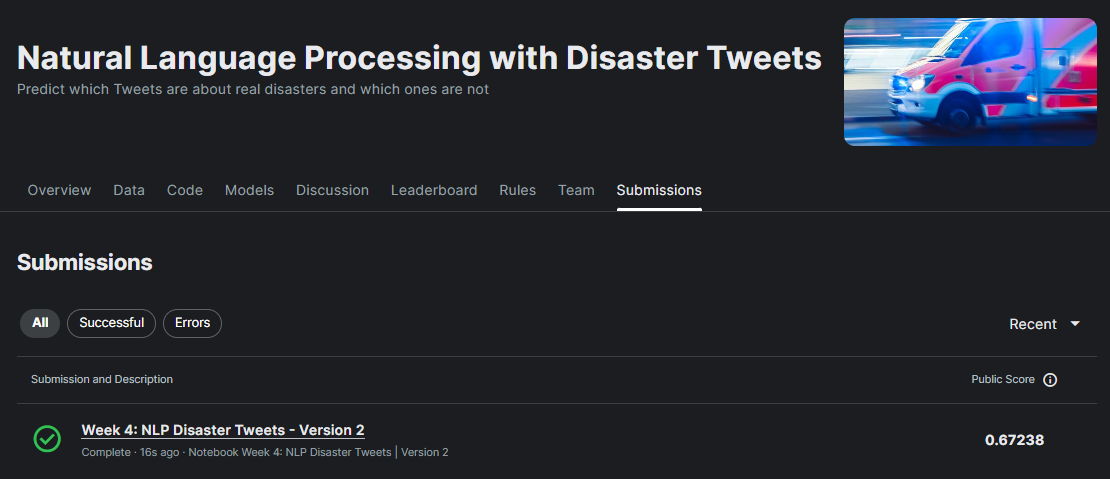

___

# Step 5: Conclusion (15 pts)
> Discuss and interpret results as well as learnings and takeaways. What did and did not help improve the performance of your models? What improvements could you try in the future?

Adding the f1 scoring to the model compilation didn't help, and it seems like the largest change happened when adjusting the learning rate.  In each iteration I was trying to get the validation scores closer to the training, but even after all these modifications, my model performed worse than my first submission. 

For the future, it would be interesting to add more layers to the network & maybe try Gated Recurrent Unit (GRU).  Some additional preprocessing & data cleaning could be helpful as well, or using more advanced embedding methods like GloVe.  

# References
1. [NLP with Disaster Tweets - EDA, Cleaning and BERTNLP with Disaster Tweets - EDA, Cleaning and BERT](https://www.kaggle.com/code/gunesevitan/nlp-with-disaster-tweets-eda-cleaning-and-bert/notebookhttps://www.kaggle.com/code/gunesevitan/nlp-with-disaster-tweets-eda-cleaning-and-bert/notebook)
2. [Basic EDA,Cleaning and GloVe](https://www.kaggle.com/code/shahules/basic-eda-cleaning-and-glove/notebook)